In [56]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from VolvoDataset import VolvoDataset
import pandas as pd
import numpy as np
import torch
import os

In [58]:
#On Jack pc
DATA_DIR = r"C:\Users\giaco\OneDrive\Desktop\TimeSeries\Volvo\train_gen1.csv"
#On Heron 
#TRAIN
DATA_DIR = r"/data1/malto/volvo_ecml_2024/train_gen1.csv"
#TEST
TEST_DATA_DIR = r"/data1/malto/volvo_ecml_2024/public_X_test.csv"


In [30]:
train_dataset = VolvoDataset(DATA_DIR)

--- Train Dataset ---
preprocessing ... 
Dropping all NaN column
Dropping all static columns
Grouping by Chassis id


In [31]:
test_dataset = VolvoDataset(TEST_DATA_DIR, test=True, columns_to_keep=train_dataset.kept_columns)

--- Test Dataset ---
Grouping by Chassis id


In [32]:
test_dataset.volvo_df.head()

,Timesteps,ChassisId_encoded,gen,af1__0,af1__1,af1__2,af1__3,af1__4,af1__5,af1__6,...,f__233,f__234,f__235,f__236,f__237,f__238,f__239,f__240,f__241,f__242
0,0.0,181.0,gen2,0.001572,0.000074,0.009537,2.436562e-07,0.005458,0.005413,0.003982,...,0.228181,2.260611,0.443237,-0.173428,-0.490855,0.027760,-0.007520,0.111756,0.713604,-0.108912
1,1.0,181.0,gen2,0.001572,0.000074,0.009537,2.436562e-07,0.005458,0.005413,0.003982,...,0.228181,2.260611,0.443237,-0.150103,-0.490656,0.016915,-0.012925,0.126104,0.752002,-0.106688
2,2.0,181.0,gen2,0.001572,0.000074,0.009537,2.436562e-07,0.005458,0.005413,0.003982,...,0.228181,2.260611,0.443237,-0.136927,-0.491369,0.014565,-0.015026,0.126458,0.764391,-0.105829
3,3.0,181.0,gen2,0.001572,0.000074,0.009537,2.436562e-07,0.005458,0.005413,0.003982,...,0.228181,2.260611,0.443237,-0.127777,-0.489940,0.016210,-0.015648,0.125425,0.760781,-0.105922
4,4.0,181.0,gen2,0.001572,0.000074,0.009537,2.436562e-07,0.005458,0.005413,0.003982,...,0.228181,2.260611,0.443237,-0.112876,-0.491121,0.014534,-0.016847,0.127709,0.782974,-0.101559


In [33]:
test_dataset.get_n_features(), train_dataset.get_n_features()

(578, 578)

In [34]:
train_dataloader = DataLoader( train_dataset, batch_size = 12, collate_fn = VolvoDataset.padding_collate_fn)
test_dataloader = DataLoader( test_dataset, batch_size = 12, collate_fn = VolvoDataset.padding_collate_fn)



In [42]:
y = [train_dataset[i][1] for i in range(len(train_dataset))]
y = torch.concat(y)
y = torch.argmax(y, dim=1)
y = y.numpy()
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
weights

array([6.28039732, 0.36585519, 9.30643731])

In [47]:
y = [torch.sum(train_dataset[i][1], dim=0) for i in range(len(train_dataset))]

ValueError: Input array must be 1 dimensional

In [8]:
train_dataset.df_list[4].shape

(13, 293)

In [9]:
for batch in train_dataloader:
    data, labels, mask = batch
    print("BEFORE")
    print(f"mask: {mask.shape}")
    print(f"data: {data.shape}")
    print(f"labels: {labels.shape}")
    
    
    mask = mask.reshape(-1)
    data = data.reshape(-1)
    labels = labels.reshape(-1,3)
    print("AFTER")    
    print(f"mask: {mask.shape}")
    print(f"data: {data.shape}")
    print(f"labels: {labels.shape}")
    
    labels = labels[ mask.type(torch.bool) ]
    
    res_df = pd.DataFrame(train_dataset.risk_encoder.inverse_transform(labels), columns=["pred"])
    #res_df.to_csv("shit.csv", index=False)
    print(mask.sum())
    break
    

BEFORE
mask: torch.Size([12, 29])
data: torch.Size([12, 29, 289])
labels: torch.Size([12, 29, 3])
AFTER
mask: torch.Size([348])
data: torch.Size([100572])
labels: torch.Size([348, 3])
tensor(245.)


In [10]:
for batch in test_dataloader:
    pass


In [11]:
import numpy as np

a = np.arange(10).reshape((5,2))
print(a)

b = a - np.roll(a, 1, axis=0)
b[0, :] = 0
b

c = np.hstack([a,b])
c

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]


array([[0, 1, 0, 0],
       [2, 3, 2, 2],
       [4, 5, 2, 2],
       [6, 7, 2, 2],
       [8, 9, 2, 2]])

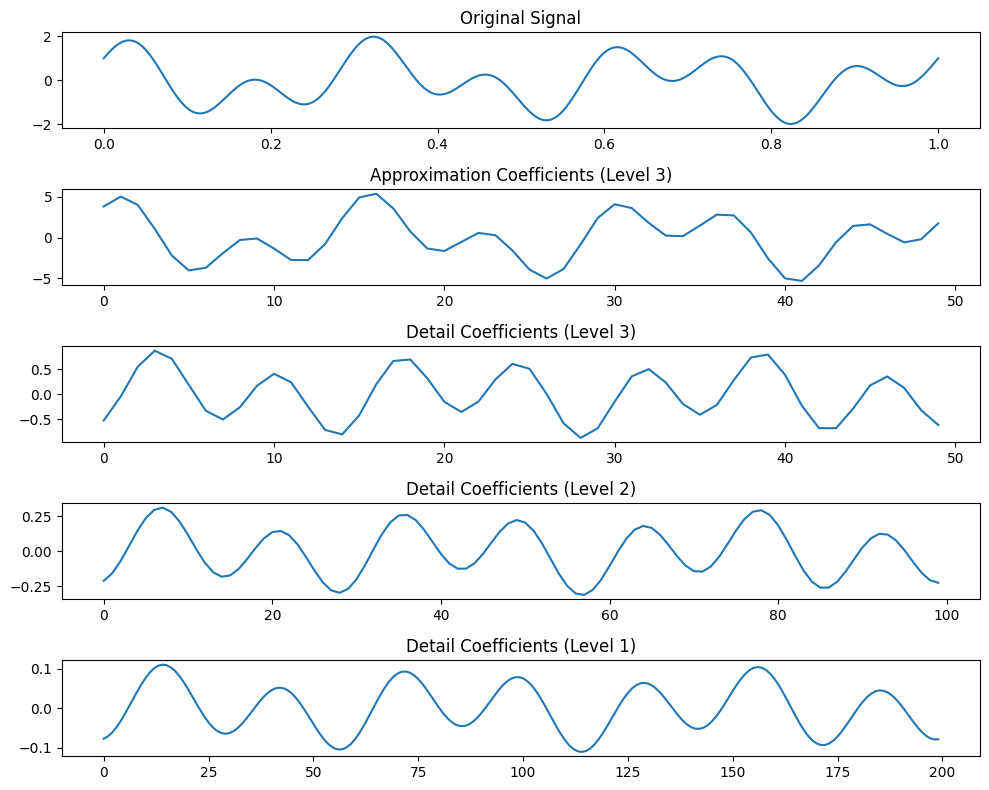

In [54]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Generate a sample signal
fs = 400  # Sampling frequency
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 7 * t) + np.cos(2 * np.pi * 3 * t)

# Perform DWT
wavelet = 'db1'  # Daubechies wavelet with 1 vanishing moment
coeffs = pywt.wavedec(signal, wavelet, level=3)

# Extract approximation and detail coefficients
cA3, cD3, cD2, cD1 = coeffs

# Plot the original signal and its wavelet decomposition
plt.figure(figsize=(10, 8))

plt.subplot(5, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')

plt.subplot(5, 1, 2)
plt.plot(cA3)
plt.title('Approximation Coefficients (Level 3)')

plt.subplot(5, 1, 3)
plt.plot(cD3)
plt.title('Detail Coefficients (Level 3)')

plt.subplot(5, 1, 4)
plt.plot(cD2)
plt.title('Detail Coefficients (Level 2)')

plt.subplot(5, 1, 5)
plt.plot(cD1)
plt.title('Detail Coefficients (Level 1)')

plt.tight_layout()
plt.show()


     A_wavelet_scale_1  A_wavelet_scale_2  A_wavelet_scale_3  \
0            -0.156843          -0.108790           0.596388   
1             0.156843           0.108790          -0.596388   
2             0.111826           0.897376          -0.997645   
3            -0.111826          -0.897376           0.997645   
4            -0.067288           0.915407           0.961289   
..                 ...                ...                ...   
123           0.000000           0.000000           0.000000   
124           0.000000           0.000000           0.000000   
125           0.000000           0.000000           0.000000   
126           0.000000           0.000000           0.000000   
127           0.000000           0.000000           0.000000   

     A_wavelet_scale_4  
0             0.050337  
1            -0.050337  
2             0.266926  
3            -0.266926  
4            -0.219530  
..                 ...  
123          -0.095257  
124          -0.440809  
125   

IndexError: single positional indexer is out-of-bounds

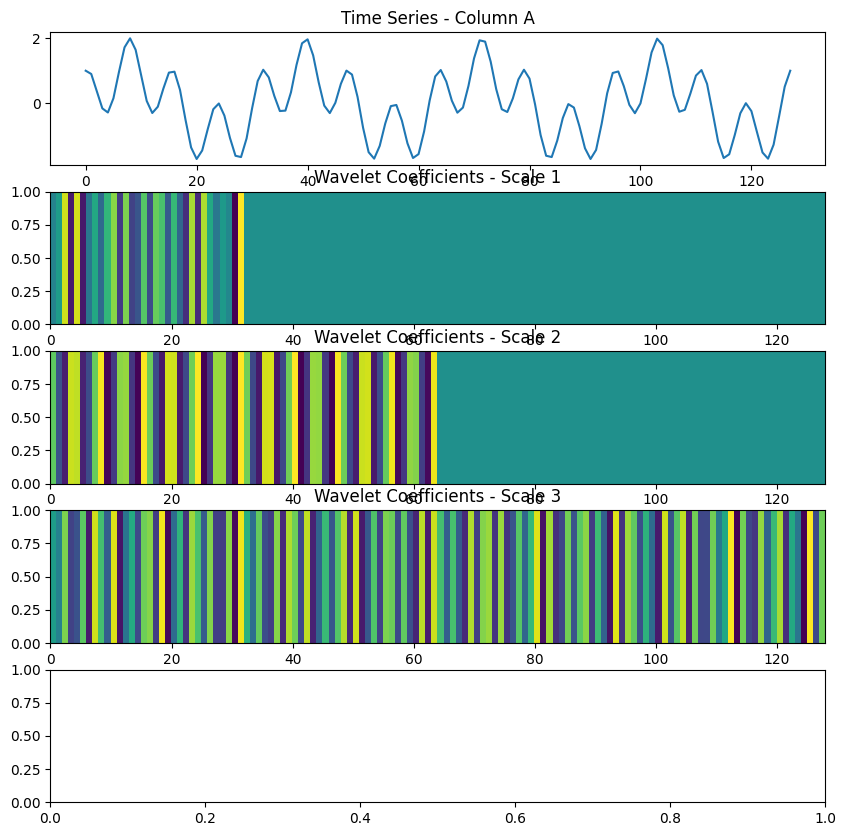

In [32]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt

def wavelet_spectrogram(df, n, wavelet='db1'):
    """
    Perform wavelet transformation on each column of the input DataFrame and return a DataFrame with the wavelet spectrogram.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with time series data.
    n (int): Number of scales to use for the wavelet transformation.
    wavelet (str): Type of wavelet to use (default is 'db1').
    
    Returns:
    pd.DataFrame: DataFrame with wavelet spectrograms, columns as signal_x_scale_y.
    """
    wavelet = pywt.Wavelet(wavelet)
    
    # Check if n is valid
    if n < 1:
        raise ValueError("Number of scales (n) must be at least 1.")
    
    num_samples = df.shape[0]
    num_features = df.shape[1]
    
    # Initialize a list to store the column names
    columns = []
    
    # Initialize a 2D array to store the wavelet spectrograms
    spectrogram = np.zeros((num_samples, num_features * (n - 1)))
    
    # Loop through each column in the DataFrame
    for i, col in enumerate(df.columns):
        series = df[col].values
        
        # Perform discrete wavelet transform up to the specified number of scales
        coeffs = pywt.wavedec(series, wavelet, level=n-1)
        
        # Add each level of detailed coefficients to the spectrogram
        for j in range(1, n):
            # Resize the coefficients to match the original series length
            cD = pywt.upcoef('d', coeffs[j], wavelet, take=num_samples)
            if len(cD) < num_samples:
                cD = np.pad(cD, (0, num_samples - len(cD)), 'constant')
            spectrogram[:, i * (n - 1) + (j - 1)] = cD
            columns.append(f'{col}_wavelet_scale_{j}')
    
    # Create the DataFrame
    spectrogram_df = pd.DataFrame(spectrogram, columns=columns)
    
    return spectrogram_df

def plot_wavelet_spectrograms(data, spectrogram_df, n):
    """
    Plot each column of the input data and its wavelet spectrogram.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame with time series data.
    spectrogram_df (pd.DataFrame): DataFrame with wavelet spectrogram data.
    n (int): Number of scales used for the wavelet transformation.
    """
    num_samples = data.shape[0]
    num_features = data.shape[1]
    time = np.arange(num_samples)
    
    for i, col in enumerate(data.columns):
        fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n))
        
        # Plot the original time series
        axes[0].plot(time, data[col].values)
        axes[0].set_title(f'Time Series - Column {col}')
        
        # Plot the wavelet spectrograms
        for j in range(1, n):
            scale_data = spectrogram_df.iloc[:, j].values
            axes[j].imshow(scale_data.reshape(-1, 1).T, aspect='auto', 
                           extent=[0, num_samples, 0, 1], cmap='viridis')
            axes[j].set_title(f'Wavelet Coefficients - Scale {j}')
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create a sample DataFrame
    samples = 128
    data = {
        'A': np.sin(np.linspace(0, 8 * np.pi, samples))+ np.cos(np.linspace(0, 32 * np.pi, samples))
    }
    df = pd.DataFrame(data)
    
    # Perform wavelet transform and get the spectrogram with 5 scales
    n = 5
    spectrogram_df = wavelet_spectrogram(df, n)
    print(spectrogram_df)
    
    # Plot each column and its spectrogram
    plot_wavelet_spectrograms(df, spectrogram_df, n)


NameError: name 'N' is not defined

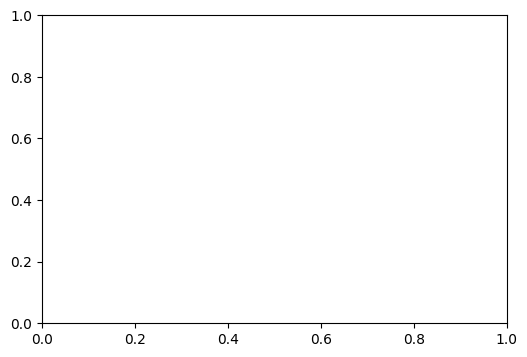

In [49]:
import scipy.signal as signal
from scipy.signal.windows import gaussian
g_std = 8  # standard deviation for Gaussian window in samples
w = gaussian(10, std=g_std, sym=True)  # symmetric Gaussian window

t = np.arange(1,32)
x = np.sin(t/(np.pi))

SFT = signal.ShortTimeFFT(w, hop=10, fs=1, mfft=200, scale_to='magnitude')
Sx = SFT.stft(x)  # perform the STFT

In [53]:
from sklearn.preprocessing import MinMaxScaler

a = np.array([[1,100,1000],
          [2,200,2000],
          [3,300,3000]])
df = pd.DataFrame(a, columns=['a','b','c'])
df2 = pd.DataFrame(a, columns=['a','b','c'])
# mm = MinMaxScaler()
# mm.fit_transform(df)
pd.concat([df,df2],axis=0,ignore_index=True)

,a,b,c
0,1,100,1000
1,2,200,2000
2,3,300,3000
3,1,100,1000
4,2,200,2000
5,3,300,3000


In [59]:
train_dataset = VolvoDataset(DATA_DIR)

--- Train Dataset ---
preprocessing ... 
Dropping all NaN column
Dropping all static columns


Group and feature extraction: 100%|██████████| 7280/7280 [00:00<00:00, 35841.64it/s]


Scaling features...done
6207


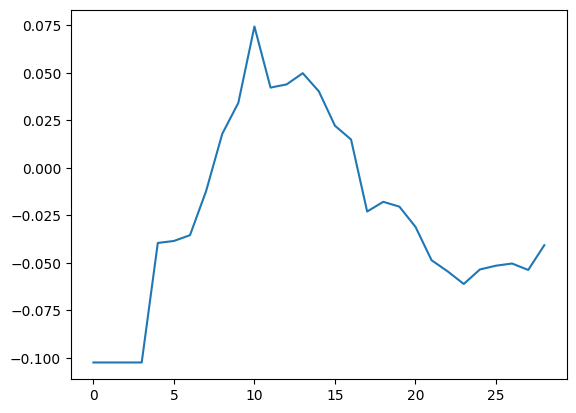

(29,)
(29, 99)


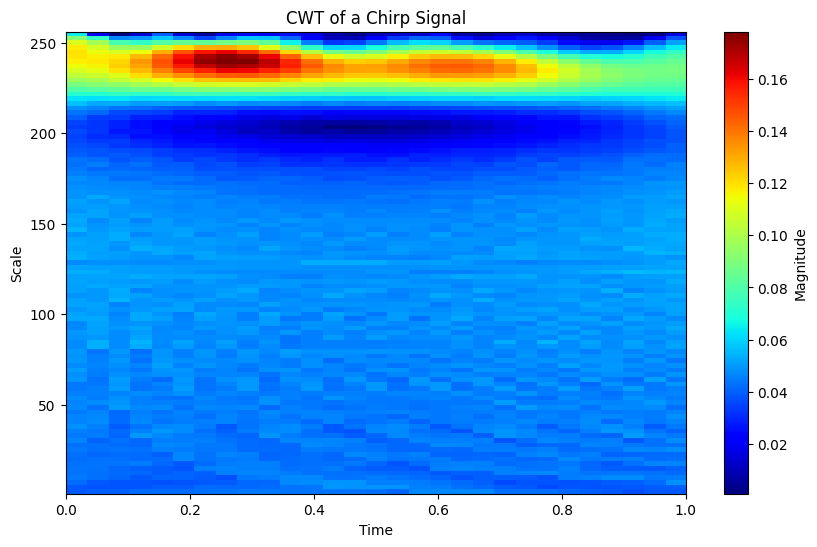

In [123]:
import pywt
from scipy.interpolate import griddata

signal = train_dataset[1][0][:, 109].numpy()
plt.plot(signal)
plt.show()

# Apply CWT
coefficients, frequencies = pywt.cwt(signal, scales=np.arange(1, 100), wavelet='cgau1')

print(signal.shape)
print(np.abs(coefficients).T.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), aspect='auto', cmap='jet', extent=[0, 1, 1, 256])
plt.colorbar(label="Magnitude")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title("CWT of a Chirp Signal")
plt.show()


        num_repeats = np.power(2, len(coeff)-1)
        repeated = np.repeat(coeff[0], num_repeats)
        mycoeff[0] = repeated[:num_samples]
        for j in range(1, len(coeff)):
            num_repeats = np.power(2, len(coeff)-j)
            repeated = np.repeat(coeff[j], num_repeats)
            mycoeff[j] = repeated[:num_samples]


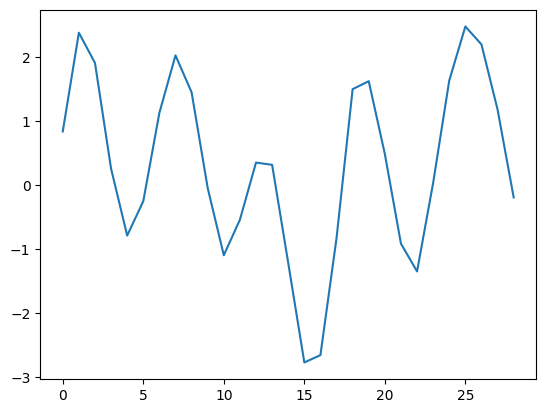

AxisError: Axis greater than data dimensions

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

num_samples = 29
t = np.arange(0,num_samples,1)
s = np.cos(6*t/(2*np.pi))+ np.sin(2*t/(2*np.pi)) + np.sin(7*t/(2*np.pi)) + np.sin(5*t/(2*np.pi)) + np.random.standard_normal(size=num_samples)/10
plt.plot(s)
plt.show()
wavelet='db1'

coeffs = pywt.wavedec(num_samples, wavelet, level=4)
        
mycoeff = np.zeros((5, num_samples))
coeff = sorted(coeffs, key=lambda l:-len(l))

for i in range(len(coeff)-1):
    num_repeats = np.power(2, i+1)
    repeated = np.repeat(coeff[i], num_repeats)
    mycoeff[i] = repeated[:num_samples]
num_repeats = np.power(2, len(coeff)-1)
repeated = np.repeat(coeff[-1], num_repeats)
mycoeff[len(coeff)-1] = repeated[:num_samples]

plt.imshow(mycoeff, aspect='auto', cmap='viridis')
plt.show()

In [8]:
import pywt

for family in pywt.families():
    fam_list = pywt.wavelist(family, kind="discrete")
    # for wlet in fam_list:
    print(fam_list)

['haar']
['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38']
['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
['coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17']
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8']
['rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8']
['dmey']
['gaus1', 'gaus2', 'gaus3', 

stft_magnitude.shape=(3, 21)


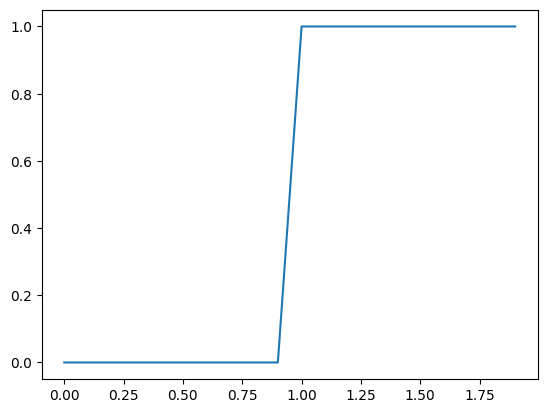

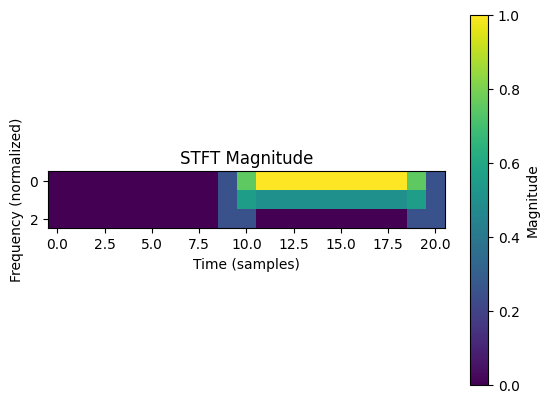

Shape of features per timestep: (21, 3)


,0,1,2
0,0.00,0.000000,0.00
1,0.00,0.000000,0.00
2,0.00,0.000000,0.00
3,0.00,0.000000,0.00
4,0.00,0.000000,0.00
5,0.00,0.000000,0.00
6,0.00,0.000000,0.00
7,0.00,0.000000,0.00
8,0.00,0.000000,0.00
9,0.25,0.250000,0.25


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample signal (for example purposes)
duration = 1  # Duration of the signal in seconds
num_samples = 10  # Number of samples in the signal
t_orig = np.linspace(0, duration, num_samples, endpoint=False)  # Time vector
signal = t_orig**3 + 0.2*np.sin(2*np.pi*t_orig * 2)+ 0.1 * np.random.normal(0, 1, num_samples)  # Sample signal

# t_orig = np.hstack([t_orig, np.linspace(duration,duration*2, num_samples, endpoint=False)])
# signal = np.hstack([0*np.ones(num_samples), np.ones(num_samples)])

from scipy.signal import stft
def my_stft(signal, window=5):
    # Parameters for STFT
    nperseg = window  # Length of each segment
    noverlap = window-1  # Number of points to overlap between segments

    # Compute the STFT
    f, t, Zxx = stft(signal, nperseg=nperseg, noverlap=noverlap, padded=True)

    # Extract features for each timestep
    # Feature extraction: Use the magnitude of the STFT coefficients as features
    stft_magnitude = np.abs(Zxx)
    return stft_magnitude

stft_magnitude = my_stft(signal, window=4)


print(f"{stft_magnitude.shape=}")
plt.plot(t_orig, signal)
plt.show()

# Plot the STFT magnitude
plt.imshow(stft_magnitude)
plt.title('STFT Magnitude')
plt.ylabel('Frequency (normalized)')
plt.xlabel('Time (samples)')
plt.colorbar(label='Magnitude')
plt.show()

# stft_magnitude is now an array where each column corresponds to a timestep
# and each row corresponds to a frequency bin.

# Example: Combine features for each timestep into a feature vector
# Each column in stft_magnitude corresponds to a timestep

features_per_timestep = stft_magnitude.T  # Shape: (num_timesteps, num_features)

print("Shape of features per timestep:", features_per_timestep.shape)

pd.DataFrame(features_per_timestep, )


In [3]:
import numpy as np
import torch

a = torch.Tensor([[1,2,3],[1,3,6]])
a.sum(dim=0)

tensor([2., 5., 9.])